In [1]:
# Import all the necessary libraries
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report


import warnings 
warnings.filterwarnings("ignore")

In [2]:
cri_compustat_merged = pd.read_pickle("cri_compustat_merged_v5.pkl")

In [5]:
cri_compustat_merged.isna().sum()

CompNo                      0
year                        0
month                       0
StkIndx                     0
STInt                       0
dtdlevel                    0
dtdtrend                    0
liqnonfinlevel              0
liqnonfintrend              0
ni2talevel                  0
ni2tatrend                  0
sizelevel                   0
sizetrend                   0
m2b                         0
sigma                       0
liqfinlevel                 0
lqfintrend                  0
DTDmedianFin                0
DTDmedianNonFin             0
dummy297fin                 0
EventDate                   0
Default                     0
StartDate                   0
Duration                    0
gvkey                       0
tic                         0
curr_ratio                  0
quick_ratio                 0
cash_ratio                  0
net_working_capital         0
debt_ratio                  0
debt_equity_ratio           0
equity_ratio                0
financial_

In [7]:
cri_compustat_merged['EventDate']

0         2016-01-31
1         2016-02-29
2         2016-09-30
3         2016-10-31
4         2016-11-30
             ...    
1146414   2013-09-30
1146415   2013-10-31
1146416   2013-11-30
1146417   2013-12-31
1146418   2014-03-31
Name: EventDate, Length: 1146419, dtype: datetime64[ns]

In [9]:
#refactor
cols = list(cri_compustat_merged.columns)

cri_compustat_merged.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1)
date2020 = datetime.datetime(2020,1,1)
train_df = cri_compustat_merged[cri_compustat_merged["EventDate"] < date2020]
validation_df = cri_compustat_merged[(cri_compustat_merged["EventDate"] >= date2020) & (cri_compustat_merged["EventDate"] < date2022)]
test_df = cri_compustat_merged[cri_compustat_merged["EventDate"] >= date2022]

In [16]:
cri_compustat_merged[cri_compustat_merged['Default'] == 1]

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,financial_leverage_ratio,net_profit_margin,roa,asset_turnover,inventory_turnover,inventory_days,receivables_turnover,working_capital_turnover,pe_ratio,retention_ratio


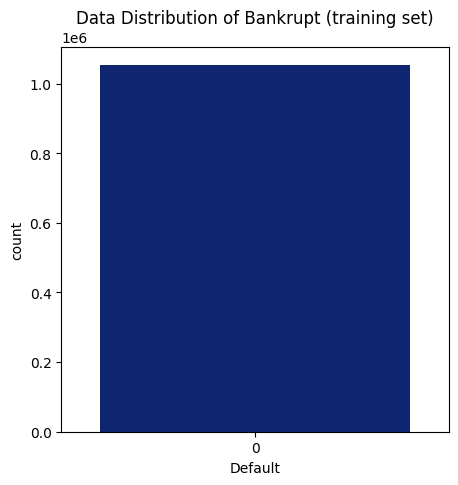

ZeroDivisionError: division by zero

In [12]:
plt.figure(figsize=(5,5))
sns.countplot(x=train_df["Default"], palette="dark")
plt.title("Data Distribution of Bankrupt (training set)")
plt.show()
majority_class_samples=train_df["Default"].loc[train_df["Default"]==0]
minority_class_samples=train_df["Default"].loc[train_df["Default"]==1]
Imbalance_Ratio= len(majority_class_samples)/len(minority_class_samples)
percentage = len(minority_class_samples)/(len(minority_class_samples)+len(majority_class_samples))
print(f"Imbalance Ratio is:{Imbalance_Ratio}")
print(f" % of default is :{percentage}") 

In [ ]:
# drop unecessary columns
train_df.drop(["CompNo", "year", "month", "day", "date"], axis=1, inplace=True)
validation_df.drop(["CompNo", "year", "month", "day", "date"], axis=1, inplace=True)
test_df.drop(["CompNo", "year", "month", "day", "date"], axis=1, inplace=True)

In [ ]:
x_train = train_df.drop('Default', axis=1)
y_train = train_df['Default']
x_validation = validation_df.drop('Default', axis=1)
y_validation = validation_df['Default']
x_test = test_df.drop('Default', axis=1)
y_test = test_df["Default"]

In [ ]:
def get_num_cat_columns(dataframe):
    categorical_cols=dataframe.select_dtypes(include="object").columns
    numerical_cols=dataframe.select_dtypes(exclude="object").columns
    
    return categorical_cols, numerical_cols

In [ ]:
categorical_cols, numerical_cols= get_num_cat_columns(x_train)

In [ ]:
def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)
        
        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)
    
    
    
    return ratio, x_train, y_train

In [ ]:
ratio, x_train, y_train= Winsorization_Method(numerical_cols, x_train, y_train,a=0.3,b=99.7)
print(f"Ratio of Outliers Detected in the dataset:{ratio}")

In [ ]:
# shape of data after removing the outliers in the training data
x_train.shape,x_test.shape,x_validation.shape ,y_train.shape, y_test.shape, y_validation.shape

In [ ]:
x_train.to_csv("Dataset/" + "X_train_winsorized.csv", index=False)

In [ ]:
x_test.to_csv("Dataset/" + "X_test.csv", index=False)

In [ ]:
x_validation.to_csv("Dataset/" + "X_validation.csv", index=False)

In [ ]:
y_train.to_csv("Dataset/" + "Y_train_winsorized.csv", index=False)

In [ ]:
y_test.to_csv("Dataset/" + "Y_test.csv", index=False)

In [ ]:
y_validation.to_csv("Dataset/" + "Y_validation.csv", index=False)